# Netflix Analysis

## <u>Introduction</u>

Our family Netflix account has been shared between 3 profiles, my brother Chase, my mother Sharleen, and myself for over a decade (2013-2024). In that time, we have all watched hundreds of movies and TV shows of different genres. My analysis will show how similar and different we are as a family when it comes to our taste and watching patterns while we are on Netflix.

To determine this, I will be answering 5 questions:

1. Which devices does each profile watch on the most for both shows and movies?
    
2. What are the most popular years, months, and days of the week each of us watch both shows and movies on?
    
3. What are the most popular titles for shows and movies by genre and profile?
    
4. What is the amount of time spent watching each genre by profile and type category?

To answer these questions, I will be using a Netflix DataMart I created that includes seven dim tables and three fact tables. However, to analyze the data I will only be using five dim tables and one fact table. The purpose of the others, (two fact and two dimension tables), is to create an easier-to-use final dim and fact table for end users that ensures data consistency. These tables will be clearly indicated in the staging and data loading processes.

### <u>Data Sources</u>

The data pulled for this analysis was provided by my Netflix BI Presentation in Power BI, and transferred to SQL using the application DAX Studios. The data was originally provided by Netflix. Below is the link to request your Netflix account data: 

[Netflix Data Request](https:\netflix.com\account\getmyinfo)

Emoji icons used in this notebook are provided by [EmojiCopy](https:\emojicopy.com\)

Visualization for the EDR is provided by [Drawio](https:\app.diagrams.net\)

## <u>Steps to Mart Creation</u>

To begin creating the Netflix DataMart, I created a new database in Microsoft SQL Server 2022 (SSMS) called "Netflix\_DW". I did this by right-clicking on 'Databases' and selecting 'New Database'. From there, I left the default sizing options, went into 'Options', set 'Recovery Mode' to 'Simple', and then pressed finish to create the new database.

Before pulling my data in, I created the schema 'stg' (shown below under 'Schema Creations') so that when I transferred my data over, I could clearly differentiate between my newly created tables and their data loading sources. Afterward, I used DAX Studio to pull in all of my dimension and fact tables from my previous Power BI presentation mentioned above in data sources. I then exported the data under the 'Export Data' pane. I selected my new database, chose the 'SQL tables' option, and used the schema 'stg' for my tables to be created under. Finally, I moved on to begin the schema creation for the new DataMart using T-SQL against SSMS.

## <u>Schema Creation</u>

Below are the four different schemas I created for the DataMart. The schema 'stg' was used to pull the data in from DAX Studios, 'vw' was used in the creation of the 'dim' and 'fact' tables, and 'dim' and 'fact' were created for the new tables that would store data and be used for analysis.

- <span style="color: var(--vscode-foreground);">stg</span>
- vw    
- dim
- fact

Below is the code used to execute the new schema names used in the DataMart table creation:

```
USE Netflix_DW;
GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'stg' ) -- created before other 3 to bring in dimension and fact tables through DAX Studio
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA dim AUTHORIZATION dbo;' -- executing the new schema through the database default schema authorization 
END
;

GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'vw' ) -- the view schema that will store views to create the dim and fact tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA stg AUTHORIZATION dbo;'
END
;

GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'dim' ) -- dim tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA fact AUTHORIZATION dbo;'
END


IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name =  'fact'  ) -- fact tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA vw AUTHORIZATION dbo;'
END

```

Once the schema names have been created, we can start to build the tables that will be used in our Netflix DataMart.

## <u>Dimension Creation</u>

Listed below are the names of the seven dimension tables that will be created:

1. dim.Calendar
2. dim.Devices
3. dim.Genres
4. dim.Profiles
5. dim.Shows (Dimension to create dim.Titles)
6. dim.Movies (Dimension to create dim.Titles)
7. dim.Titles (Final dimension for shows and movies)

The tables 'dim.Shows' and 'dim.Movies' have been brought in separately containing fields for each type(shows and movies). However, since this will create longer queries, require me to continously 'UNION' or 'UNION ALL' the data, and create room for errors in the analysis, they will be combined in our final product to create dim.Titles. This way, we will have all our Netflix titles in one table and data in each column will be consistent between the two category types. 

  

Below is the code for creating our dimensions:

### <u>Dimension #1) dim.Calendar</u>

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Calendar')
BEGIN -- Beginning the table creation
    CREATE TABLE dim.Calendar( 
       PK_CalendarDate DATE NOT NULL, 
       Year INT NOT NULL, 
       Month TINYINT NOT NULL, 
       MonthName NVARCHAR(10) NULL,
       Day TINYINT NOT NULL,
       DayName NVARCHAR(10) NULL,
       Weekend NVARCHAR(3) NULL, 
       WeekofYear TINYINT NOT NULL 
       );

    ALTER TABLE dim.Calendar 
    ADD CONSTRAINT PK_Date PRIMARY KEY(PK_CalendarDate); 

END -- Ending the table creation

```

### <u>**Explanation for dim.Calendar**</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME = 'Calendar' :** Placing the new dimension table under the 'dim' schema and naming it

**PK_CalendarDate :** The column all the dates from December 1st of 2013 to October 20th 2024 will fall, DATE as the data type, and NOT NULL so each needs a date

**Year:** Column for the year within the date, INT (integer large enough for years for the data type), NOT NULL since the year is derived from the 'Date' column

**Month:** Column for the month within the date, TINYINT (integers will range from 1 to 12 for data type), NOT NULL (derived from 'Date' column)

**MonthName:** Column for the month within the date, TINYINT (integers will range from 1 to 12 for data type), NOT NULL (derived from 'Date' column)

**Day:** Column for the day of the month, TINYINT (Days ranging from 1 to 31 in a month), NOT NULL (derived from 'Date' column)

**DayName:** The name of the day of week for the day column above, NVARCHAR(10) (Days can be up to 10 letters long), NULL since we have 'Day' column can fix

**Weekend:** Column that says if it is a weekend day or not, (Y) for Yes, (N) for No, NVARCHAR(3) (only need up to 3 letters for Y and N)

**WeekofYear:** The week of the year from the date, TINYINT (integer ranging from 1-52), NOT NULL since derived from 'Date' column

**ADD CONSTRAINT PK_Date:** Adding a primary key constraint so that each date must be unique in the table


### <u>Dimension #2) dim.Devices</u>

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Devices') 
BEGIN
    CREATE TABLE dim.Devices( 
       Device_ID TINYINT NOT NULL,  
       Device_Type NVARCHAR(50) NULL, 
       Times_Device_Used SMALLINT NOT NULL, 
       Device_Usage NVARCHAR(20) NULL 
       );

    ALTER TABLE dim.Devices
    ADD CONSTRAINT PK_Devices PRIMARY KEY(Device_ID); 

END

```

### <u>**Explanation for dim.Devices**</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Devices':** Using 'dim' schema, creating the table name

**Device_ID:** The unique identifier for each device, TINYINT since there are 46 devices, on this account most likely will stay a two digit number, NOT NULL 

**Device_Type:** The name of the device that was used, NVARCHAR(50) (Device names can be up to 50 characters long), NULL since we have Device_ID

**Times_Device_Used:** The amount of times the device has been used (opening the Netflix site or app), SMALLINT (digits in thousands), NOT NULL since using measure  
 
**Device_Usage:** A SWITCH expression created to categorize devices by how much they were used from 'Low Usage' to 'Extreme Usage', NVARCHAR(20) (up to 20 characters), NULL (not necessary to analysis)

**ADD CONSTRAINT PK_Devices:** Setting a primary key on the 'Device_ID' column so that each device is unique in the table

### <u>Dimension #3) dim.Genres</u>

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Genres')
BEGIN
    CREATE TABLE dim.Genres(
       Genre_ID TINYINT NOT NULL,
       Genre NVARCHAR(25) NOT NULL 
       );

    ALTER TABLE dim.Genres
    ADD CONSTRAINT PK_Genre PRIMARY KEY(Genre_ID); 

END

```

### **<u>Explanation for dim.Genres</u>**

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Genres':** Using 'dim' schema, creating the name of the table

**Genre_ID:** The unique identifier for each genre, TINYINT since there are 19 genres used and will likely stay two digit number, NOT NULL

**Genre:** The name of the genre for each watched, NVARCHAR(25) so genres can be up to 25 characters, NOT NULL since used often in analysis rather than ID

**ADD CONSTRAINT PK_Genre:** Setting a primary key on the 'Genre_ID' column so that each genre is unique

### <u>Dimension #4) dim.Profiles</u>

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Profiles') 
BEGIN
    CREATE TABLE dim.Profiles(
       Profile_ID TINYINT NOT NULL, 
       Profile_Name NVARCHAR(10) NOT NULL 
       );

    ALTER TABLE dim.Profiles 
    ADD CONSTRAINT PK_Profile PRIMARY KEY(Profile_ID);  

    ALTER TABLE dim.Profiles
    ADD CONSTRAINT UC_Profile UNIQUE (Profile_Name);               

END

```

### **<u>Explanation for dim.Profiles</u>**

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Profiles':** Using the 'dim' schema, creating the name of the table

**Profile_ID:** The unique identifier for each profile, TINYINT since there are only 3 used and likely will stay a single digit number, NOT NULL

**Profile_Name:** The name for each Profile, NVARCHAR(10) since only first names of family members, NOT NULL since used often in analysis rather than ID

**ADD CONSTRAINT PK_Profile:** Setting a primary key on the 'Profile_ID' column so that each profile is unique

**ADD CONSTRAINT UC_Profile:** Setting the 'Profile_Name' column to be unique, each profile must have a different name so data collected is clear for each profile

### <u>Dimension #5) dim.Shows</u>

```
--First table for the creation of our final dimension table we will use in our analysis

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Shows') 
BEGIN
    CREATE TABLE dim.Shows(
       ShowID SMALLINT NOT NULL,
       Show_Name NVARCHAR(100) NOT NULL, 
       Genre NVARCHAR(25) NOT NULL, 
       );

END                   

```

### **<u>Explanation for dim.Shows</u>**

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Shows':** Using the 'dim' schema and creating the name of the table

**ShowID:** The unique identifier for each show coming from the dim.Shows table in PowerBI file, will later be changed,SMALLINT (show go up to 508), NOT NULL 

**Show_Name:** The name of each show watched, NVARCHAR(100) allowing names to go up to 100 characters, NOT NULL since often used rather than ID

**Genre:** The genre that is associated to each show, NVARCHAR(25) allowing genres to be 25 characters like dim.Genres table, NOT NULL (same as dim.Genres)

****For this dimension, we will not be setting any keys since this is not the final product and will not be used in our analysis**

### <u>Dimension #6) dim.Movies</u>

```
-- Second table for the creation of our final dimension table we will use in our analysis                                                                                                                                                                   IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Movies') 
BEGIN
    CREATE TABLE dim.Movies(
       MovieID SMALLINT NOT NULL, 
       Movie_Name NVARCHAR(100) NOT NULL,
       Genre NVARCHAR(25) NOT NULL, 
       );

END                    

```

### **<u>Explanation for dim.Movies</u>**

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Movies':** Using the 'dim' schema, and creating the table name

**MovieID:** The unique identifier for each movie coming from the dim.Movies table in PowerBI file, will later be changed,SMALLINT(movies go up to 1409), NOT NULL

**Movie_Name:** The name of each movie watched, NVARCHAR(100) allowing names to go up to 100 characters, NOT NULL since often used rather than ID

**Genre:** The genre that is associated to each movie, NVARCHAR(25) allowing genres to be 25 characters like dim.Genres table, NOT NULL (same as dim.Genres)

****For this dimension, we will not be setting any keys since this is not the final product and will not be used in our analysis**

### <u>Dimension #7) dim.Titles</u>

```
--The dimension table that will be created by combining dim.Shows and dim.Movies together, the table that we will be using in our analysis

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Titles') 
BEGIN
    CREATE TABLE dim.Titles ( 
       PK_MovieShow_ID INT IDENTITY(1,1) NOT NULL, 
       Title VARCHAR(100) NOT NULL,  
       Genre NVARCHAR(25) NOT NULL, 
       Title_ID SMALLINT NULL, 
       [Type] NVARCHAR(6) NULL, 
       );

    ALTER TABLE dim.Titles
    ADD CONSTRAINT NetflixID PRIMARY KEY(PK_MovieShow_ID);                                                                                                                                                            END
```

### **<u>Explanation for dim.Titles</u>**

**IF NOT EXISTS SCHEMA 'dim' TABLE_NAME 'Titles':** Using the 'dim' schema and creating the name of the table

**PK_MovieShow_ID:** Creating the PK_Movie_Show_ID column so we are able to join both dim tables together
>Unique identifier for both movies and shows, INT(larger ID numbers), IDENTITY(1,1), starts at 1, increments by 1, NOT NULL(ID)

**Title:** The title of the movie/show, VARCHAR(100) like dim.Shows and dim.Movies, NOT NULL since often used rather than ID in analysis

**Genre:** The genre associated to each movie/show, NVARCHAR(25) like dim.Genres, NOT NULL since often used in analysis rather than Genre ID

**Title_ID:** The new unique ID that will replace ShowID and MovieID when combining both tables, SMALLINT(like dim.Shows, dim.Movies), NULL (explanation below)

**Type:** The type of category (Show or Movie) of each Title to identify each, NVARCHAR(6) allowing 6 characters, NULL since not unique & can be entered manually

**ADD CONSTRAINT NetflixID:** Setting a primary key for the PK_MovieShow_ID column since each value must be unique 
                                                                    

```
***In the dim.Titles table above, the Title_ID is left as 'NULL' since we will need to create these new IDs and insert them into the table during the data loading process. If we set them as 'NOT NULL', the table will require something in the fields and will create difficulties will trying to combine and insert data from dim.Shows and dim.Movies later. We will later set these as unique so that there will not be duplicates and change the type to 'NOT NULL' after the new ID's are inserted into the table.
```

We have now finished creating all of our dimension tables, and begin creating our three fact tables.

## <u>Fact Table Creation</u>

Listed below are the three fact tables that will be created:

1. <span style="color: var(--vscode-foreground);">fact.NetflixShows (Fact table to create fact.Netflix)</span>
2. <span style="color: var(--vscode-foreground);">fact.NetflixMovies (Fact table to create fact.Netflix)</span>
3. <span style="color: var(--vscode-foreground);">fact.Netflix (Final fact table for Netflix shows and movies)</span>

Similar to the dimension tables dim.Shows and dim.Movies, having two separate fact tables creates room for error in the data analysis, creates longer queries, and with both tables holding the 'Total Duration' for each type, it is best to have them combined so that our values are consistent and easier to work with. A single fact table also aligns much better with our final dimension table dim.Titles.

Note that in the fact table creation, (required) next to 'NOT NULL' signifies that the column is required since we will need to create relationships between our fact and dimension tables for accurate analysis.

Below is the code for creating our facts:

### <u>Fact #1) fact.NetflixShows</u>

```
-- First fact to create or final fact table we will use in the analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'NetflixShows') -- Using the schema 'fact', and creating the name of the table
BEGIN
    CREATE TABLE fact.NetflixShows ( -- Creating IDENTITY(1,1) so that each is given their own ID that will later be used to combine fact.NetflixShows and fact.NetflixMovies
        PK_Shows_ID INT IDENTITY(1,1) NOT NULL, -- The identity of each show viewing in the fact table, will later be changed, INT (allowing for large numbers), NOT NULL (unique)
        [Date] DATE NOT NULL, -- The date of each viewing session for each profile, so that dim.Calendar will have a relationship with our final fact, DATE datatype, NOT NULL (required)
        Show_Name NVARCHAR(100) NOT NULL, -- The name of the show associated to the viewing session, will be changed, NVARCHAR(100) like dim.Shows, NOT NULL (used in analysis not ID)
        Profile_ID TINYINT NOT NULL, -- The Profile_ID for each viewing session, will have a relationship with dim.Profiles, TINYINT (single digit ID's), NOT NULL (required)
        Show_ID SMALLINT NOT NULL, -- The ID of each show, will be changed like 'dim.Shows' table to match the Title_ID in the final dim, SMALLINT(up to 508), NOT NULL (required)
        Genre_ID TINYINT NOT NULL, -- The Genre_ID associated to each viewing session, will have a relationship with dim.Genres, TINYINT(up to 19), NOT NULL (required)
        Device_ID TINYINT NOT NULL, -- The Device_ID associated to each viewing session, will have a relationship with dim.Devices, TINYINT(up to 46), NOT NULL (required)
        Total_Duration FLOAT NOT NULL -- The amount of time spent in each viewing session, FLOAT (numbers came in as decimals from PowerBI, will be casted in queries), NOT NULL (required)
        );
END                      -- Not setting any primary or foreign keys on this table since it is not the final table we will be using 

```

### <u>Fact #2) Fact.NetflixMovies</u>

```
-- Second fact to create our final fact table we will use in the analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'NetflixMovies')
BEGIN
    CREATE TABLE fact.NetflixMovies ( -- Creating IDENTITY(1,1) so that each is given their own ID that will later be used to combine fact.NetflixShows and fact.NetflixMovies
        PK_Movies_ID INT IDENTITY(1,1) NOT NULL, -- The identity of each movie viewing in the fact table, will later be changed, INT (allowing for large numbers), NOT NULL (unique)
        [Date] DATE NOT NULL, -- The date of each viewing session for each profile, so that dim.Calender will have a relationship with our final fact, DATE datatype, NOT NULL (required)
        Movie_Name NVARCHAR(100) NOT NULL, -- The name of the movie associated to the viewing session, will be changed, NVARCHAR(100) like dim.Movies, NOT NULL (used in analysis not ID)
        Profile_ID TINYINT NOT NULL, -- The Profile_ID for each viewing session, will have a relationship with dim.Profiles, TINYINT (single digit ID's), NOT NULL (required)
        Movie_ID SMALLINT NOT NULL, -- The ID of each movie, will be changed like 'dim.Movies' table to match the Title_ID in the final dim, SMALLINT(up to 1409), NOT NULL (required)
        Genre_ID TINYINT NOT NULL, -- The Genre_ID associated to each viewing session, will have a relationship with dim.Genres, TINYINT(up to 19), NOT NULL (required)
        Device_ID TINYINT NOT NULL, -- The Device_ID associated to each viewing session, will have a relationship with dim.Devices, TINYINT(up to 46), NOT NULL (required)
        Total_Duration FLOAT NOT NULL -- The amount of time spent in each viewing session, FLOAT (numbers came in as decimals from PowerBI), NOT NULL (necessary for analysis)
    );
END                          -- Not setting any primary or foreign keys on this table since it is notn the final table we will be using

```

### <u>Fact #3) Fact.Netflix</u>

```
--The fact table that will be created by combining fact.NetflixShows and fact.NetflixMovies together, the table we will be using in our analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'Netflix') -- Using the schema 'fact', creating the name for the table
BEGIN
    CREATE TABLE fact.Netflix (
        PK_Netflix_ID INT IDENTITY(1,1) NOT NULL, -- The unique identifier for both movie/show viewings, INT(larger numbers), IDENTITY(1,1), start at 1, increment by 1, NOT NULL(unique)
        [Date] DATE NOT NULL, -- The date for each viewing session for movies/shows, connected to dim.Calendar, DATE datatype, NOT NULL (required)
        Title NVARCHAR(100) NOT NULL, -- The name for the movie/show, NVARCHAR(100) (matching fact & dim tables NVARCHAR characters), NOT NULL (required)
        Profile_ID TINYINT NOT NULL, -- The Profile_ID associated to each viewing session, connected to dim.Profiles, TINYINT(single digit numbers), NOT NULL (required)
        Title_ID SMALLINT NOT NULL, -- The identifier for each movie/show title, this value will take on the Title_ID from dim.Titles, SMALLINT(taken from other IDs), NOT NULL (required)
        Genre_ID TINYINT NOT NULL, -- The Genre_ID associated to each viewing session, connected to dim.Genres, TINYINT (double digits), NOT NULL (required)
        Device_ID TINYINT NOT NULL, -- The Device_ID associated to each viewing session, connected to dim.Devices, TINYINT (double digits), NOT NULL (required)
        Total_Duration FLOAT NOT NULL -- The amount of time spent watching shows/movies each viewing session, FLOAT (same type as previous facts), NOT NULL (necessary for analysis)            ;


    ALTER TABLE fact.Netflix 
    ADD CONSTRAINT PK_Netflix PRIMARY KEY (PK_Netflix_ID); --Setting the primary key on the PK_Netflix_ID viewing session so each is unique

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoCAL
    FOREIGN KEY ([Date])                  --Connecting the dim.Calendar table through a foreign key to the fact.Netflix table 'Date' column
    REFERENCES dim.Calendar(PK_CalendarDate);    

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoPROFILE
    FOREIGN KEY (Profile_ID)             --Connecting the dim.Profiles table through a foreign key to the fact.Netflix table 'Profile_ID' column
    REFERENCES dim.Profiles(Profile_ID);

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoDEVICE
    FOREIGN KEY (Device_ID)               --Connecting the dim.Devices table through a foregn key to the fact.Netflix table 'Device_ID' column
    REFERENCES dim.Devices(Device_ID);
     
    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoGENRE
    FOREIGN KEY (Genre_ID)                --Connecting the dim.Genres table through a foreign key to the fact.Netflix table 'Genre_ID' column
    REFERENCES dim.Genres (Genre_ID);ADD CONSTRAINT FK_NETFLIXtoGENRE
    
END                                       

```

```
***For the foreign key that connects dim.Titles to fact.Netflix, we will wait to create it afterwards along with our unique identifier once the tables are combined, this way there are no restrictions when building the tables in the data loading process.
```

Our fact tables are now created and ready to for the data loading process.

## <u>EDR Diagram of Netflix DataMart</u>

Below is an image constructed to show the final product of our dimension and fact creation, note that the two fact and two dimension tables we will not be using are placed to the below since they are only temporary tables in the Netflix DataMart:

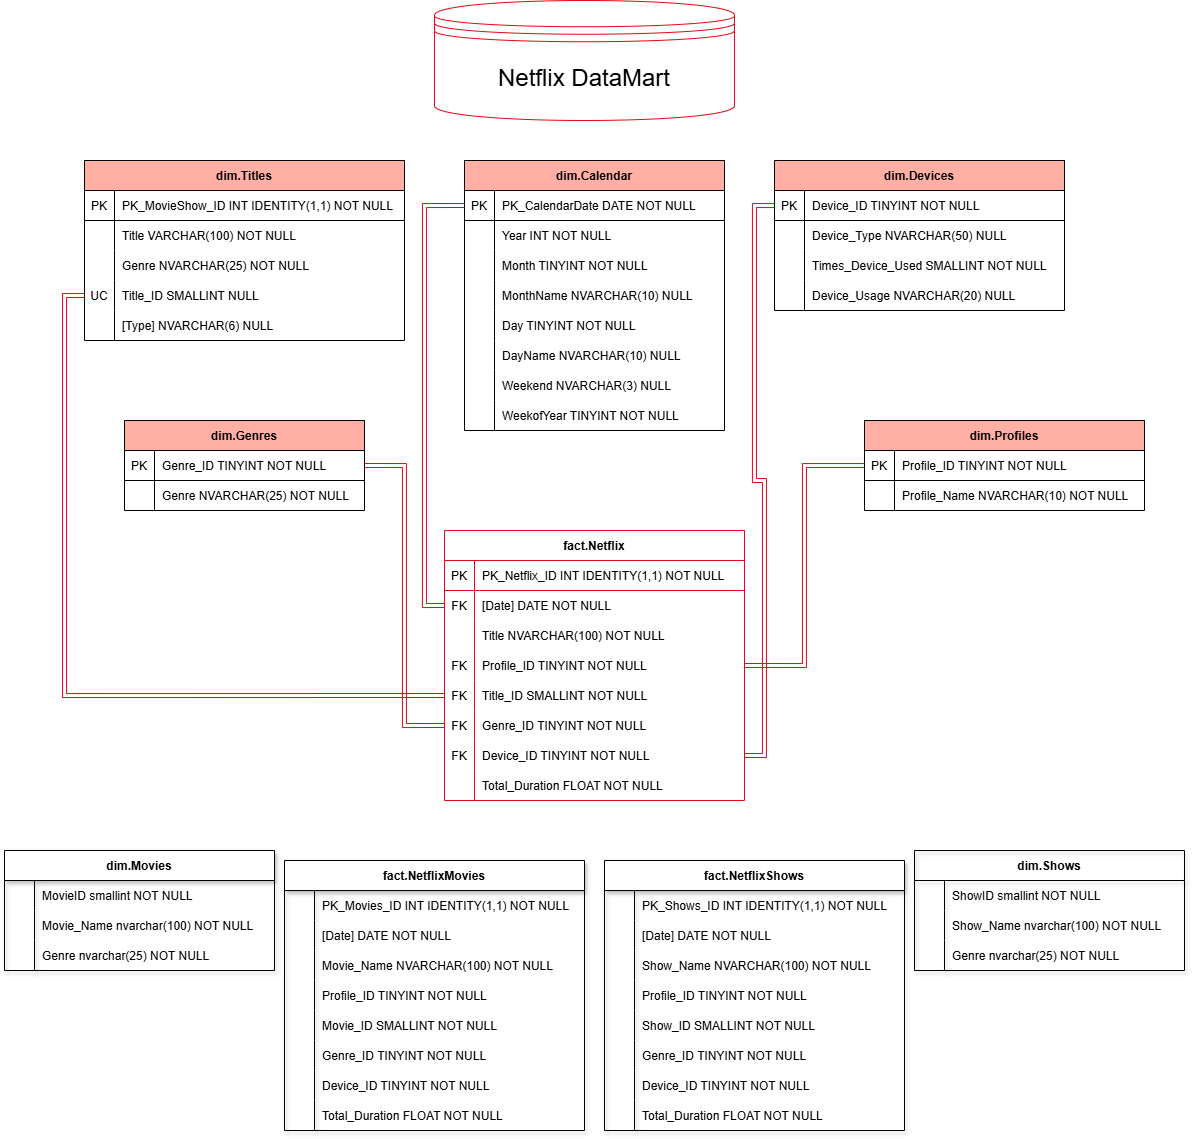